# Weather Transformer: Multi-Variate Forecasting

This notebook trains a Transformer model to predict multiple weather variables simultaneously.
- **Input**: 7 days (168 hours) of weather features
- **Output**: 3 days (72 hours) of predictions for multiple variables
- **Model**: Transformer with self-attention mechanism

## 1. Setup & Installation

In [1]:
# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install pandas numpy scikit-learn matplotlib tqdm

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import math
import os
from google.colab import files
import json

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Device: cuda
GPU: Tesla T4
Memory: 15.83 GB


## 2. Upload Dataset
Upload your `Weather_Data_1980_2024(hourly).csv` file when prompted

In [3]:
# Upload dataset
uploaded = "/content/Weather_Data_1980_2024(hourly).csv"

## 3. Configuration

In [4]:
# Configuration for multi-variate prediction
config = {
    # Data settings
    'input_window': 168,  # 7 days
    'output_window': 72,  # 3 days

    # Features to use (you can modify this list)
    'input_features': [
        'temperature',
        'relative_humidity',
        'dew_point',
        'wind_speed_10m (km/h)',
        'pressure_msl (hPa)',
        'cloud_cover (%)',
        'vapour_pressure_deficit (kPa)'
    ],

    # Variables to predict (subset of input_features)
    'output_variables': [
        'temperature',
        'relative_humidity',
        'wind_speed_10m (km/h)'
    ],

    # Model architecture
    'model_dim': 128,
    'num_heads': 8,
    'num_layers': 3,
    'dropout': 0.1,

    # Training settings
    'batch_size': 32,
    'epochs': 20,
    'learning_rate': 0.001,
    'train_split': 0.8,
    'val_split': 0.1,  # Remaining 0.1 for test
}

# Calculate dimensions
config['input_dim'] = len(config['input_features'])
config['output_dim'] = len(config['output_variables'])

print("Configuration:")
print(json.dumps(config, indent=2))

Configuration:
{
  "input_window": 168,
  "output_window": 72,
  "input_features": [
    "temperature",
    "relative_humidity",
    "dew_point",
    "wind_speed_10m (km/h)",
    "pressure_msl (hPa)",
    "cloud_cover (%)",
    "vapour_pressure_deficit (kPa)"
  ],
  "output_variables": [
    "temperature",
    "relative_humidity",
    "wind_speed_10m (km/h)"
  ],
  "model_dim": 128,
  "num_heads": 8,
  "num_layers": 3,
  "dropout": 0.1,
  "batch_size": 32,
  "epochs": 20,
  "learning_rate": 0.001,
  "train_split": 0.8,
  "val_split": 0.1,
  "input_dim": 7,
  "output_dim": 3
}


## 4. Dataset Class

In [5]:
class WeatherDataset(Dataset):
    def __init__(self, csv_file, config, split='train'):
        self.config = config
        self.df = pd.read_csv(csv_file)

        # Select features
        self.input_features = config['input_features']
        self.output_variables = config['output_variables']

        # Get output variable indices
        self.output_indices = [self.input_features.index(var) for var in self.output_variables]

        # Clean data
        self.df = self.df[self.input_features].dropna().reset_index(drop=True)

        # Normalize
        self.scaler = MinMaxScaler()
        self.data_normalized = self.scaler.fit_transform(self.df[self.input_features])

        # Split data
        total_len = len(self.data_normalized)
        train_len = int(config['train_split'] * total_len)
        val_len = int(config['val_split'] * total_len)

        if split == 'train':
            self.data = self.data_normalized[:train_len]
        elif split == 'val':
            self.data = self.data_normalized[train_len:train_len + val_len]
        else:  # test
            self.data = self.data_normalized[train_len + val_len:]

        print(f"{split.upper()} dataset: {len(self.data)} samples")

    def __len__(self):
        return len(self.data) - self.config['input_window'] - self.config['output_window']

    def __getitem__(self, idx):
        # Input: all features for input_window
        x = self.data[idx:idx + self.config['input_window']]

        # Output: selected variables for output_window
        y_full = self.data[idx + self.config['input_window']:
                          idx + self.config['input_window'] + self.config['output_window']]
        y = y_full[:, self.output_indices]

        return (
            torch.tensor(x, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32)
        )

## 5. Model Architecture

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class MultiVariateTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Input projection
        self.input_proj = nn.Linear(config['input_dim'], config['model_dim'])

        # Positional encoding
        self.pos_encoding = PositionalEncoding(config['model_dim'], config['dropout'])

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config['model_dim'],
            nhead=config['num_heads'],
            dropout=config['dropout'],
            batch_first=True,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, config['num_layers'])

        # Output projection
        # Output: [batch, output_window * output_dim]
        self.output_proj = nn.Sequential(
            nn.Linear(config['model_dim'], config['model_dim'] * 2),
            nn.GELU(),
            nn.Dropout(config['dropout']),
            nn.Linear(config['model_dim'] * 2, config['output_window'] * config['output_dim'])
        )

    def forward(self, x):
        # x: [batch, input_window, input_dim]
        x = self.input_proj(x)
        x = self.pos_encoding(x)
        x = self.transformer(x)

        # Use mean pooling over time dimension
        x = x.mean(dim=1)  # [batch, model_dim]

        # Project to output
        output = self.output_proj(x)  # [batch, output_window * output_dim]

        # Reshape to [batch, output_window, output_dim]
        output = output.view(-1, self.config['output_window'], self.config['output_dim'])

        return output

## 6. Training Functions

In [7]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    pbar = tqdm(train_loader, desc='Training', leave=False)
    for batch_idx, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}',
                         'avg_loss': f'{total_loss/(batch_idx+1):.4f}'})

    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc='Validating', leave=False):
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            total_loss += loss.item()

    return total_loss / len(val_loader)

## 7. Create Data Loaders

In [8]:
# Create datasets
train_dataset = WeatherDataset(uploaded, config, split='train')
val_dataset = WeatherDataset(uploaded, config, split='val')
test_dataset = WeatherDataset(uploaded, config, split='test')

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

print(f"\nData Loaders Created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

TRAIN dataset: 311596 samples
VAL dataset: 38949 samples
TEST dataset: 38951 samples

Data Loaders Created:
  Train batches: 9730
  Val batches: 1210
  Test batches: 1210


## 8. Initialize Model

In [9]:
# Create model
model = MultiVariateTransformer(config).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel initialized on {device}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Optimizer and loss
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
criterion = nn.MSELoss()


Model initialized on cuda
Total parameters: 1,868,632
Trainable parameters: 1,868,632


## 9. Training Loop

In [10]:
# Training history
history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')

print("\n" + "="*60)
print("Starting Training")
print("="*60)

for epoch in range(1, config['epochs'] + 1):
    start_time = time.time()

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

    # Validate
    val_loss = validate(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step()

    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'config': config,
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, 'best_multivariate_model.pth')
        print(f"  💾 Saved best model (val_loss: {val_loss:.4f})")

    # Print progress
    epoch_time = time.time() - start_time
    print(f"\nEpoch {epoch}/{config['epochs']}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  LR: {scheduler.get_last_lr()[0]:.6f}")
    print(f"  Time: {epoch_time:.1f}s")
    print("-"*40)

print("\n✅ Training completed!")


Starting Training


  💾 Saved best model (val_loss: 0.0062)

Epoch 1/20:
  Train Loss: 0.0071
  Val Loss: 0.0062
  LR: 0.000994
  Time: 376.7s
----------------------------------------


  💾 Saved best model (val_loss: 0.0057)

Epoch 2/20:
  Train Loss: 0.0056
  Val Loss: 0.0057
  LR: 0.000976
  Time: 375.4s
----------------------------------------



Epoch 3/20:
  Train Loss: 0.0052
  Val Loss: 0.0061
  LR: 0.000946
  Time: 375.8s
----------------------------------------



Epoch 4/20:
  Train Loss: 0.0048
  Val Loss: 0.0062
  LR: 0.000905
  Time: 375.5s
----------------------------------------



Epoch 5/20:
  Train Loss: 0.0042
  Val Loss: 0.0064
  LR: 0.000854
  Time: 375.9s
----------------------------------------



Epoch 6/20:
  Train Loss: 0.0035
  Val Loss: 0.0071
  LR: 0.000794
  Time: 375.3s
----------------------------------------



Epoch 7/20:
  Train Loss: 0.0029
  Val Loss: 0.0073
  LR: 0.000727
  Time: 378.2s
----------------------------------------



Epoch 8/20:
  Train Loss: 0.0024
  Val Loss: 0.0075
  LR: 0.000655
  Time: 377.9s
----------------------------------------



Epoch 9/20:
  Train Loss: 0.0021
  Val Loss: 0.0076
  LR: 0.000578
  Time: 377.7s
----------------------------------------



Epoch 10/20:
  Train Loss: 0.0019
  Val Loss: 0.0077
  LR: 0.000500
  Time: 377.7s
----------------------------------------



Epoch 11/20:
  Train Loss: 0.0017
  Val Loss: 0.0078
  LR: 0.000422
  Time: 377.0s
----------------------------------------



Epoch 12/20:
  Train Loss: 0.0016
  Val Loss: 0.0080
  LR: 0.000345
  Time: 377.5s
----------------------------------------



Epoch 13/20:
  Train Loss: 0.0014
  Val Loss: 0.0080
  LR: 0.000273
  Time: 376.8s
----------------------------------------



Epoch 14/20:
  Train Loss: 0.0014
  Val Loss: 0.0080
  LR: 0.000206
  Time: 377.6s
----------------------------------------



Epoch 15/20:
  Train Loss: 0.0013
  Val Loss: 0.0080
  LR: 0.000146
  Time: 377.2s
----------------------------------------



Epoch 16/20:
  Train Loss: 0.0012
  Val Loss: 0.0081
  LR: 0.000095
  Time: 377.2s
----------------------------------------



Epoch 17/20:
  Train Loss: 0.0012
  Val Loss: 0.0081
  LR: 0.000054
  Time: 376.8s
----------------------------------------



Epoch 18/20:
  Train Loss: 0.0011
  Val Loss: 0.0081
  LR: 0.000024
  Time: 376.8s
----------------------------------------



Epoch 19/20:
  Train Loss: 0.0011
  Val Loss: 0.0081
  LR: 0.000006
  Time: 376.9s
----------------------------------------



Epoch 20/20:
  Train Loss: 0.0011
  Val Loss: 0.0081
  LR: 0.000000
  Time: 377.5s
----------------------------------------

✅ Training completed!


## 10. Visualize Training

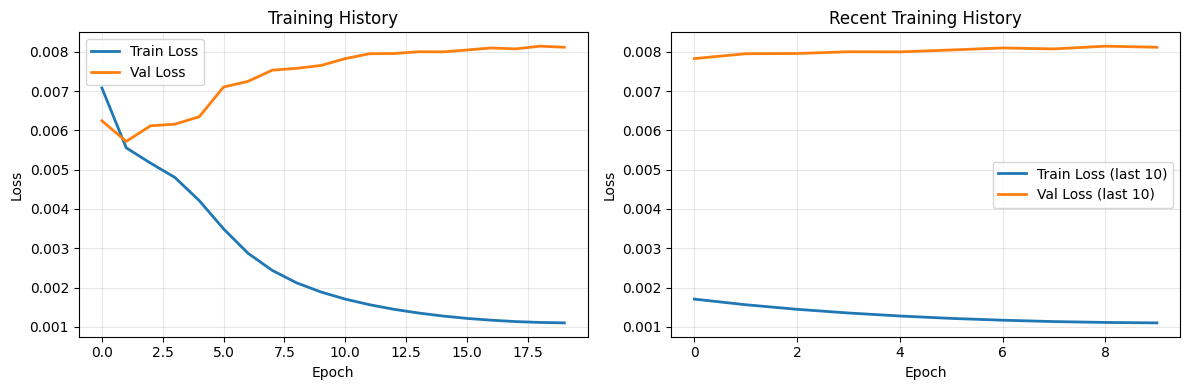

In [11]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'][-10:], label='Train Loss (last 10)', linewidth=2)
plt.plot(history['val_loss'][-10:], label='Val Loss (last 10)', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Recent Training History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Test Model & Visualize Predictions

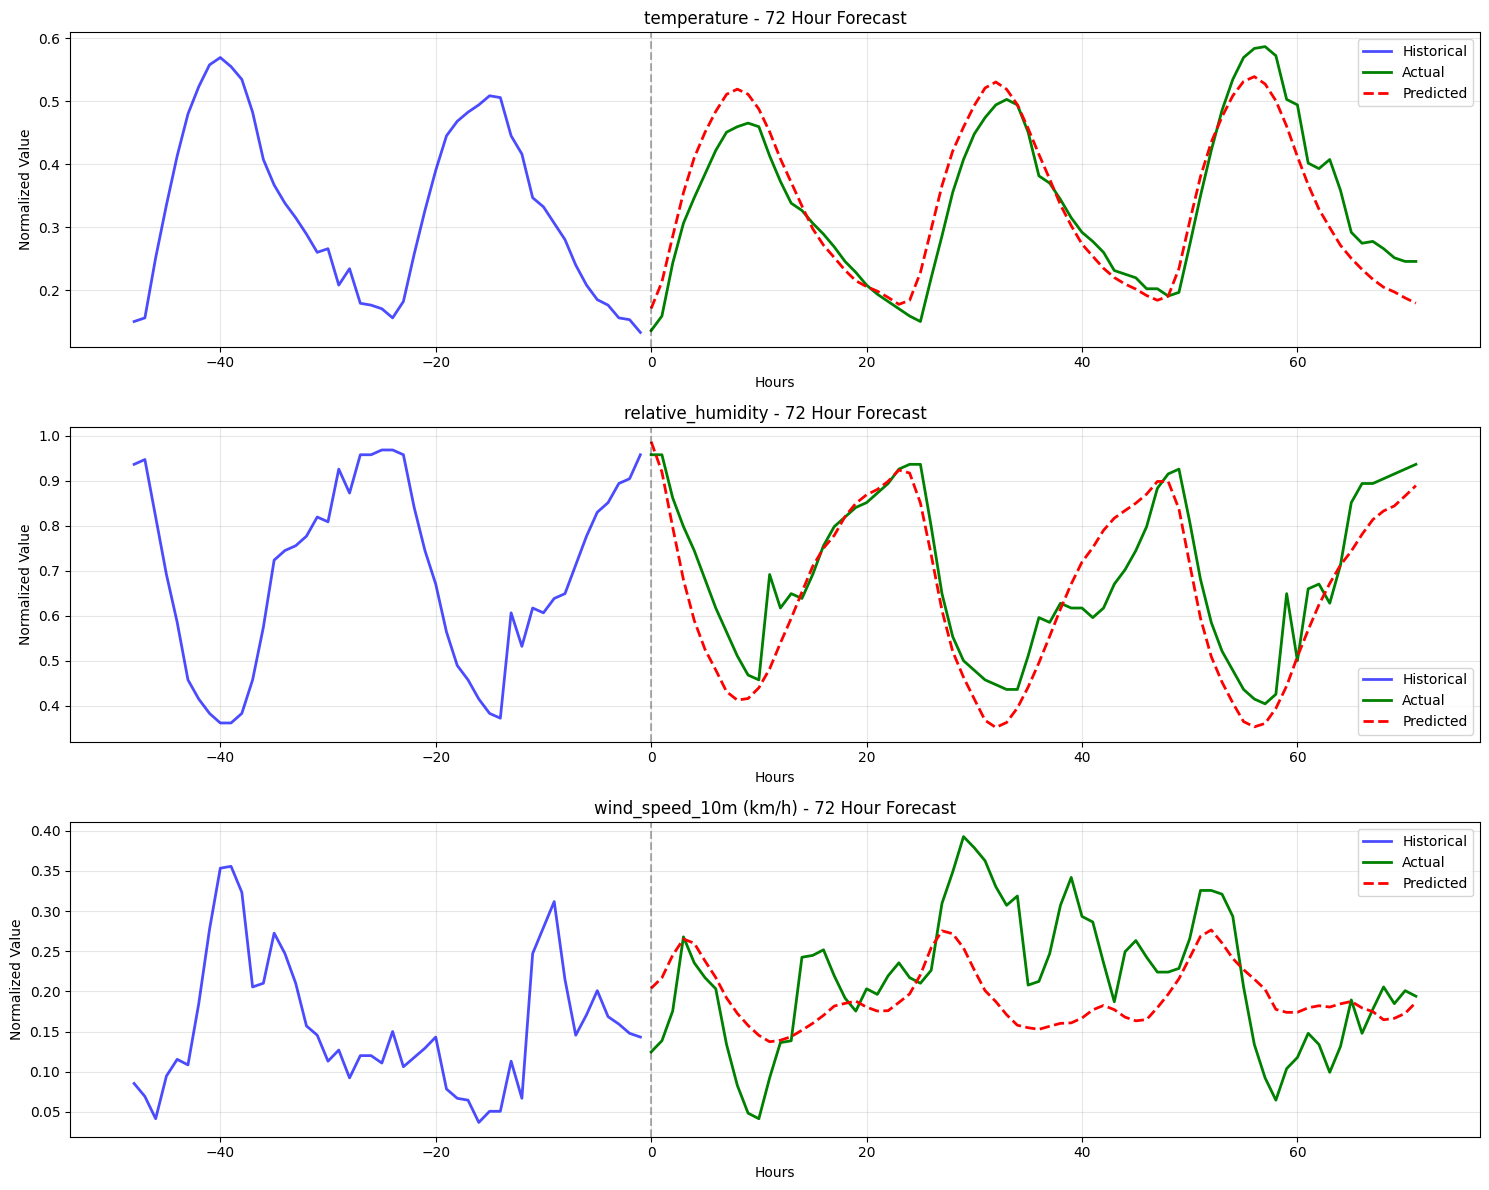


Test Loss: 0.0065


In [12]:
# Load best model
checkpoint = torch.load('best_multivariate_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Get a test batch
test_iter = iter(test_loader)
x_test, y_test = next(test_iter)
x_test, y_test = x_test.to(device), y_test.to(device)

# Make predictions
with torch.no_grad():
    y_pred = model(x_test)

# Convert to numpy for plotting
x_test_np = x_test.cpu().numpy()
y_test_np = y_test.cpu().numpy()
y_pred_np = y_pred.cpu().numpy()

# Plot predictions for first sample
sample_idx = 0
fig, axes = plt.subplots(len(config['output_variables']), 1, figsize=(15, 4*len(config['output_variables'])))

if len(config['output_variables']) == 1:
    axes = [axes]

for i, var_name in enumerate(config['output_variables']):
    ax = axes[i]

    # Plot history (last 48 hours of input)
    history_hours = 48
    var_idx = config['input_features'].index(var_name)
    historical = x_test_np[sample_idx, -history_hours:, var_idx]

    # Time arrays
    hist_time = np.arange(-history_hours, 0)
    pred_time = np.arange(0, config['output_window'])

    # Plot
    ax.plot(hist_time, historical, 'b-', label='Historical', alpha=0.7, linewidth=2)
    ax.plot(pred_time, y_test_np[sample_idx, :, i], 'g-', label='Actual', linewidth=2)
    ax.plot(pred_time, y_pred_np[sample_idx, :, i], 'r--', label='Predicted', linewidth=2)

    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Normalized Value')
    ax.set_title(f'{var_name} - 72 Hour Forecast')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate test metrics
test_loss = validate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}")

## 12. Calculate Per-Variable Metrics

In [13]:
# Calculate MSE per variable
model.eval()
variable_mse = {var: [] for var in config['output_variables']}

with torch.no_grad():
    for x, y in tqdm(test_loader, desc='Calculating metrics'):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)

        for i, var_name in enumerate(config['output_variables']):
            mse = ((y_pred[:, :, i] - y[:, :, i]) ** 2).mean().item()
            variable_mse[var_name].append(mse)

# Average MSE per variable
print("\nPer-Variable Test MSE:")
for var_name in config['output_variables']:
    avg_mse = np.mean(variable_mse[var_name])
    print(f"  {var_name}: {avg_mse:.6f}")

Calculating metrics: 100%|██████████| 1210/1210 [00:12<00:00, 97.62it/s]


Per-Variable Test MSE:
  temperature: 0.001990
  relative_humidity: 0.009455
  wind_speed_10m (km/h): 0.008182


## 13. Download Trained Model

In [ ]:
# Download the trained model
files.download('best_multivariate_model.pth')
print("✅ Model downloaded! You can now use it for inference in your local application.")

## 14. Save Model for Local Use

In [15]:
# Save just the model state dict for easier loading
torch.save(model.state_dict(), 'multivariate_model_weights.pth')
files.download('multivariate_model_weights.pth')

# Save configuration
with open('model_config.json', 'w') as f:
    json.dump(config, f, indent=2)
files.download('model_config.json')

print("✅ Model weights and configuration saved separately for local deployment!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Model weights and configuration saved separately for local deployment!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Model weights and configuration saved separately for local deployment!


## Next Steps

1. **Modify Input Features**: Edit the `input_features` list in the config to use more weather variables
2. **Change Output Variables**: Edit `output_variables` to predict different combinations
3. **Tune Hyperparameters**: Adjust model_dim, num_heads, num_layers for better performance
4. **Extend Forecast Window**: Increase `output_window` for longer predictions
5. **Add More Data**: Include additional years or data sources

To use the trained model locally:
```python
# Load config
with open('model_config.json', 'r') as f:
    config = json.load(f)

# Create model
model = MultiVariateTransformer(config)
model.load_state_dict(torch.load('multivariate_model_weights.pth'))
model.eval()
```